In [1]:
# This notebook is for resting-state functional networks calculation based on gradient-weighted cortical maps.

# Includes:
#    loding cortical surface data
#    saving cortical surface data to dataframe and csv
#    loading network txt
#    displaying cortical network and gradient network histogram

In [1]:
import os
from numpy import load
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import pandas as pd
import nibabel as nib
from nilearn import datasets, plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from brainspace.datasets import load_fsa5, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_parcellation
from brainspace.utils.parcellation import map_to_labels
from neuromaps import images
from statannotations.Annotator import Annotator
import pingouin as pg

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


### Setting the path

In [1]:
main_path = "/srv/khan/users/sudesnac/00_Projects/"
#main_path = "/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/"

In [3]:
# get the current notebook path
note_path = main_path + "/HumanBF-Parcellation/notebook/"
data_path = main_path + "/HumanBF-Parcellation/data/"
results_path = main_path + "/HumanBF-Parcellation/results/Networks/"
fig_path = main_path + "/HumanBF-Parcellation/results/Networks/figures/"

In [4]:
Func_results = main_path + "/HumanBF-Parcellation/results/Func_HCPMMP/"
Diff_results = main_path + "/HumanBF-Parcellation/results/Diff_7Tsubj/"
Fuse_results = main_path + "/HumanBF-Parcellation/results/Fusion_grad/"

### loading gradient-weighted maps

In [6]:
# loading specified gradient data
gradi = 1
grad_L = images.load_gifti(Func_results_path+f'Func_HCPMMP_Gradient-{gradi}_weighted_L_fsa-10k.gii')
grad_R = images.load_gifti(Func_results_path+f'Func_HCPMMP_Gradient-{gradi}_weighted_R_fsa-10k.gii')
grad_L_data = grad_L.agg_data()
grad_R_data = grad_R.agg_data()
grad_data = np.concatenate((grad_L_data, grad_R_data))

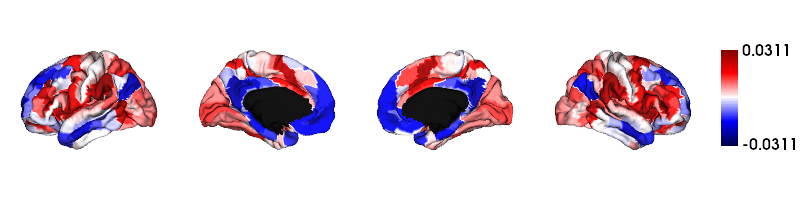

In [7]:
# Checking the cortical surface data
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[grad_data], size=(800, 200), cmap=['seismic'], color_range='sym', color_bar=True, embed_nb=True)

In [8]:
Gcortex_df = pd.DataFrame()
for gradi in (n+1 for n in range(2)):
    grad_L = images.load_gifti(Func_results_path+f'Func_HCPMMP_Gradient-{gradi}_weighted_L_fsa-10k.gii')
    grad_R = images.load_gifti(Func_results_path+f'Func_HCPMMP_Gradient-{gradi}_weighted_R_fsa-10k.gii')
    grad_L_data = grad_L.agg_data()
    grad_R_data = grad_R.agg_data()
    grad_data = np.concatenate((grad_L_data, grad_R_data))
    Gcortex_df[gradi] = pd.DataFrame(grad_data)

In [9]:
pd.DataFrame(Gcortex_df).to_csv(results_path + 'Func_HCPMMP_Gradient-weighted_cortical_data.csv', index=False)

In [10]:
func_Gcortex = pd.read_csv(results_path + 'Func_HCPMMP_Gradient-weighted_cortical_data.csv')

In [11]:
func_Gcortex.shape

(20484, 2)

In [12]:
# loading specific gradiet data
gradi = 1
grad_L = images.load_gifti(Diff_results_path+f'Diff_7Tsubj_Gradient-{gradi}_weighted_L_fsa-10k.gii')
grad_R = images.load_gifti(Diff_results_path+f'Diff_7Tsubj_Gradient-{gradi}_weighted_R_fsa-10k.gii')
grad_L_data = grad_L.agg_data()
grad_R_data = grad_R.agg_data()
grad_data = np.concatenate((grad_L_data, grad_R_data))

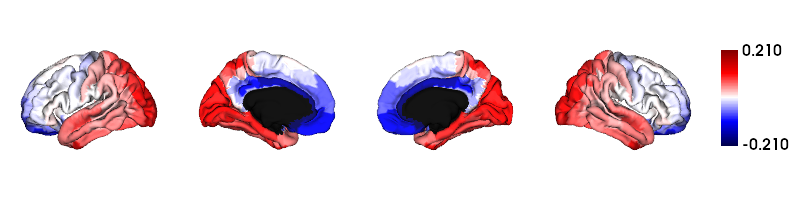

In [13]:
# Checking the cortical surface data
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[grad_data], size=(800, 200), cmap=['seismic'], color_range='sym', color_bar=True, embed_nb=True)

In [14]:
diff_Gcortex_df = pd.DataFrame()
for gradi in (n+1 for n in range(4)):
    grad_L = images.load_gifti(Diff_results_path+f'Diff_7Tsubj_Gradient-{gradi}_weighted_L_fsa-10k.gii')
    grad_R = images.load_gifti(Diff_results_path+f'Diff_7Tsubj_Gradient-{gradi}_weighted_R_fsa-10k.gii')
    grad_L_data = grad_L.agg_data()
    grad_R_data = grad_R.agg_data()
    grad_data = np.concatenate((grad_L_data, grad_R_data))
    diff_Gcortex_df[gradi] = pd.DataFrame(grad_data)

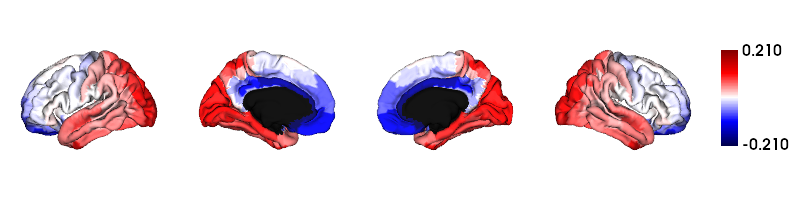

In [15]:
# Checking the cortical surface data
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[diff_Gcortex_df[1].to_numpy()], size=(800, 200), cmap=['seismic'], color_range='sym', color_bar=True, embed_nb=True)

In [16]:
pd.DataFrame(diff_Gcortex_df).to_csv(results_path + 'Diff_7Tsubj_Gradient-weighted_cortical_data.csv', index=False)

In [17]:
diff_Gcortex = pd.read_csv(results_path + 'Diff_7Tsubj_Gradient-weighted_cortical_data.csv')

In [18]:
diff_Gcortex.shape

(20484, 4)

### Loading gradient weighted cortical connectivity data

In [6]:
Func_GCtx = np.load(Func_results + 'Func_HCPMMP_Gradient-weighted_CorticalConnectivity.npz')
Func_GCtx.files

['G1_Ctx', 'G2_Ctx', 'G3_Ctx', 'G4_Ctx']

In [8]:
Diff_GCtx = np.load(Diff_results + 'Diff_7Tsubj_Gradient-weighted_CorticalConnectivity.npz')
Diff_GCtx.files

['G1_Ctx', 'G2_Ctx', 'G3_Ctx', 'G4_Ctx', 'G5_Ctx', 'G6_Ctx']

In [9]:
Fuse_GCtx = np.load(Fuse_results + 'Fused-matrix_Gradient-weighted_CorticalConnectivity.npz')
Fuse_GCtx.files

['G1_Ctx', 'G2_Ctx', 'G3_Ctx', 'G4_Ctx', 'G5_Ctx', 'G6_Ctx']

### Network coloring and surface projection

#### manual coloring

In [47]:
labels_txt = pd.read_csv(data_path+'hcp_mmp10_yeo7_modes.txt',header=None)

In [48]:
labels_txt[['Label','Hemisphere','Area','ROI','Network#','Network']]= labels_txt[0].str.split('_',expand=True)
networks = labels_txt['Network'].unique()
num_network = labels_txt['Network#'].unique()

In [49]:
color_txt = pd.read_csv(data_path+'Yeo2011_7Networks_ColorLUT_modified.csv')

In [50]:
# Set the Yeo7 color same as freesurfer https://surfer.nmr.mgh.harvard.edu/fswiki/CorticalParcellation_Yeo2011 
colorLUT = ((255,255,255),
         (120,  18, 134),
         (70 ,130, 180),
         ( 0 ,118 , 14),
         (196 , 58 ,250),
         (220 ,248 ,164),
         (230, 148,  34),
         (205 , 62,  78 ))

In [51]:
cols = np.asarray(colorLUT, dtype=float)/255
yeoCols = ListedColormap(cols, name='Yeo7colormap')

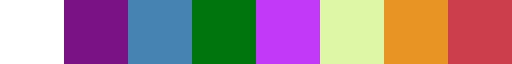

In [52]:
# show the yeo 7 network color
yeoCols

In [53]:
# load the yeo7 network surface gii files
yeo7L = nib.load(data_path + 'hcp.RSN.L.gii').darrays[0].data
yeo7R = nib.load(data_path + 'hcp.RSN.R.gii').darrays[0].data
yeo7 = np.concatenate((yeo7L, yeo7R))
yeo7.shape

(64984,)

In [54]:
# change the number so coloring matches with the network
uniqueY = np.array(np.unique(yeo7), dtype=np.int32)[1::]
convertYeo7 = [2,5,6,0,4,1,3]
yeo7Lnet = yeo7L.copy()
for n, v in enumerate(uniqueY):
    yeo7Lnet[yeo7L == v] = int(convertYeo7[n]) - 3
yeo7Lnet[yeo7L == 37] = - 4

In [55]:
yeo7net = np.concatenate((yeo7Lnet, yeo7Lnet))

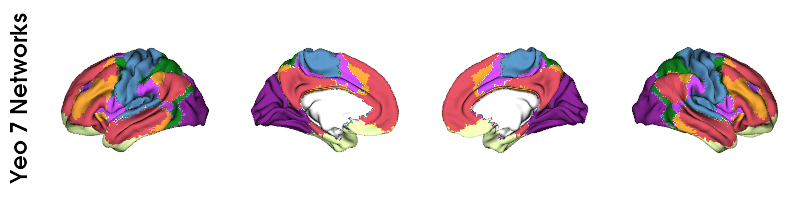

In [32]:
surf_lh, surf_rh = load_conte69()
plot_hemispheres(surf_lh, surf_rh, array_name=[yeo7net], size=(800, 200), cmap=[yeoCols], embed_nb=True, label_text=['Yeo 7 Networks'], filename=fig_path+'Yeo_7_Networks_surface.png'
)

#### Yeo network from brainstat

In [5]:
from matplotlib.colors import ListedColormap
from brainstat.datasets import fetch_mask, fetch_template_surface
from brainstat.datasets import fetch_parcellation
from brainspace.plotting.surface_plotting import plot_hemispheres
from brainstat.datasets import fetch_yeo_networks_metadata

surfaces = fetch_template_surface("fsaverage5", join=False)
yeo_networks = fetch_parcellation("fsaverage5", "yeo", 7)
network_names, yeo_colormap = fetch_yeo_networks_metadata(7)
yeo_colormap_gray = np.concatenate((np.array([[0.7, 0.7, 0.7]]), yeo_colormap))
yeoCols = ListedColormap(yeo_colormap_gray, name='yeo_colormap')

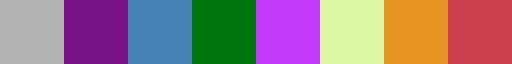

In [7]:
yeoCols

In [8]:
# Setting the color for 7 networks
yeo_cols = {"Visual":yeoCols.colors[1,:], "Somatomotor":yeoCols.colors[2,:], "Dorsal Attention":yeoCols.colors[3,:], "Ventral Attention":yeoCols.colors[4,:], "Default":yeoCols.colors[5,:], "Frontoparietal":yeoCols.colors[6,:], "Limbic":yeoCols.colors[7,:]}

In [9]:
from matplotlib.colors import rgb2hex
[ rgb2hex(yeoCols.colors[i,:]) for i in range(yeoCols.colors.shape[0]) ]

['#b2b2b2',
 '#781286',
 '#4682b4',
 '#00760e',
 '#c43afa',
 '#dcf8a4',
 '#e69422',
 '#cd3e4e']

In [10]:
net_cols = {"Visual":"#781286", "Somatomotor":"#4682b4", "Dorsal Attention":"#00760e", "Ventral Attention":"#c43afa", "Default":"#dcf8a4", "Frontoparietal":"#e69422", "Limbic":"#cd3e4e"}

/tmp/ipykernel_35610/947717499.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


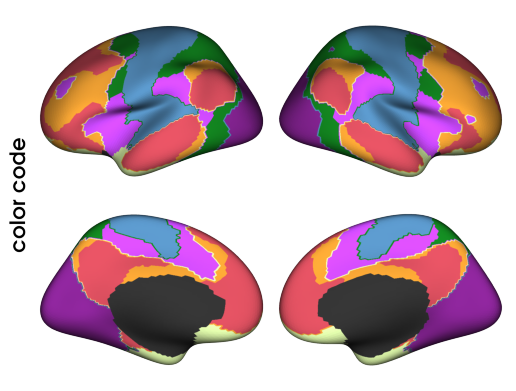

In [6]:
# Visualize
# plot both BF and geodic distance together
from neuromaps.datasets import fetch_fsaverage
from surfplot import Plot

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), label_text={'left':['color code']}, brightness=.8)
p.add_layer(yeo_networks, cmap=yeoCols, cbar=False)
fig = p.build()
fig.show()
#fig.savefig(fig_path+'Yeo_7_Networks_inflated_surface_grid.png', dpi=300, bbox_inches='tight')

### Calculating network association with cortical maps

#### Functional data

In [14]:
# getting cortical data
Func_GCtx.files

['G1_Ctx', 'G2_Ctx', 'G3_Ctx', 'G4_Ctx']

In [15]:
func_g1 = pd.DataFrame(Func_GCtx['G1_Ctx'])
func_g2 = pd.DataFrame(Func_GCtx['G2_Ctx'])

In [16]:
net_mean = []
funcG1_net = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con_df = func_g1.iloc[:,net_inds]
    net_mean = net_con_df.mean()
    funcG1_net[str(nets)] = pd.Series(net_mean.values)

In [17]:
net_mean = []
funcG2_net = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con_df = func_g2.iloc[:,net_inds]
    net_mean = net_con_df.mean()
    funcG2_net[str(nets)] = pd.Series(net_mean.values)

In [19]:
# Saving network data
pd.DataFrame(funcG1_net).to_csv(results_path + 'Func_HCPMMP_G1-Gradient-weighted_cortical_networks.csv', index=False)
pd.DataFrame(funcG2_net).to_csv(results_path + 'Func_HCPMMP_G2-Gradient-weighted_cortical_networks.csv', index=False)

#### Structural data

In [29]:
# getting srtuctural cortical data
Diff_GCtx.files

['G1_Ctx', 'G2_Ctx', 'G3_Ctx', 'G4_Ctx', 'G5_Ctx', 'G6_Ctx']

In [30]:
diff_g1 = pd.DataFrame(Diff_GCtx['G1_Ctx'])
diff_g2 = pd.DataFrame(Diff_GCtx['G2_Ctx'])
diff_g3 = pd.DataFrame(Diff_GCtx['G3_Ctx'])
diff_g4 = pd.DataFrame(Diff_GCtx['G4_Ctx'])

In [31]:
net_mean = []
diffG1_net = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con_df = diff_g1.iloc[:,net_inds]
    net_mean = net_con_df.mean()
    diffG1_net[str(nets)] = pd.Series(net_mean.values)

In [32]:
net_mean = []
diffG2_net = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con_df = diff_g2.iloc[:,net_inds]
    net_mean = net_con_df.mean()
    diffG2_net[str(nets)] = pd.Series(net_mean.values)

In [33]:
net_mean = []
diffG3_net = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con_df = diff_g3.iloc[:,net_inds]
    net_mean = net_con_df.mean()
    diffG3_net[str(nets)] = pd.Series(net_mean.values)

In [34]:
net_mean = []
diffG4_net = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con_df = diff_g4.iloc[:,net_inds]
    net_mean = net_con_df.mean()
    diffG4_net[str(nets)] = pd.Series(net_mean.values)

In [35]:
# Saving network data
pd.DataFrame(diffG1_net).to_csv(results_path + 'Diff_7Tsubj_G1-Gradient-weighted_cortical_networks.csv', index=False)
pd.DataFrame(diffG2_net).to_csv(results_path + 'Diff_7Tsubj_G2-Gradient-weighted_cortical_networks.csv', index=False)
pd.DataFrame(diffG3_net).to_csv(results_path + 'Diff_7Tsubj_G3-Gradient-weighted_cortical_networks.csv', index=False)
pd.DataFrame(diffG4_net).to_csv(results_path + 'Diff_7Tsubj_G4-Gradient-weighted_cortical_networks.csv', index=False)

### Loading the cortical network data from saved csv

In [11]:
# getting cortical network datas for graphs
funcG1_net = pd.read_csv(results_path + 'Func_HCPMMP_G1-Gradient-weighted_cortical_networks.csv')
funcG2_net = pd.read_csv(results_path + 'Func_HCPMMP_G2-Gradient-weighted_cortical_networks.csv')

In [12]:
# getting cortical network datas for graphs
diffG1_net = pd.read_csv(results_path + 'Diff_7Tsubj_G1-Gradient-weighted_cortical_networks.csv')
diffG2_net = pd.read_csv(results_path + 'Diff_7Tsubj_G2-Gradient-weighted_cortical_networks.csv')
diffG3_net = pd.read_csv(results_path + 'Diff_7Tsubj_G3-Gradient-weighted_cortical_networks.csv')
diffG4_net = pd.read_csv(results_path + 'Diff_7Tsubj_G4-Gradient-weighted_cortical_networks.csv')

#### test plot network with Ploty

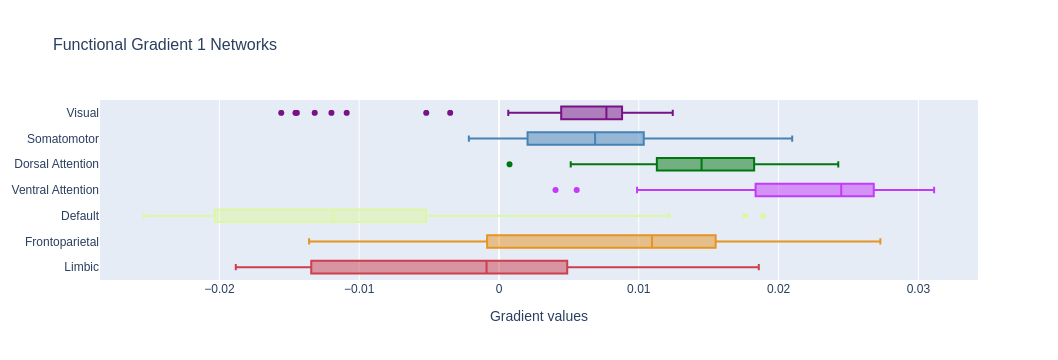

In [29]:
import plotly.graph_objects as go
fig = go.Figure()
# Use x instead of y argument for horizontal plot
fig.add_trace(go.Box(x=funcG1_net['Limbic'], name="Limbic",  marker_color="#cd3e4e"))
fig.add_trace(go.Box(x=funcG1_net['Frontoparietal'], name="Frontoparietal", marker_color="#e69422"))
fig.add_trace(go.Box(x=funcG1_net['Default'], name="Default",  marker_color="#dcf8a4"))
fig.add_trace(go.Box(x=funcG1_net['Ventral Attention'], name="Ventral Attention",  marker_color="#c43afa"))
fig.add_trace(go.Box(x=funcG1_net['Dorsal Attention'], name="Dorsal Attention", marker_color="#00760e"))
fig.add_trace(go.Box(x=funcG1_net['Somatomotor'], name="Somatomotor", marker_color="#4682b4"))
fig.add_trace(go.Box(x=funcG1_net['Visual'], name="Visual",  marker_color="#781286"))
fig.update_layout(title_text="Functional Gradient 1 Networks", showlegend=False, title_font_size=16, xaxis_title="Gradient values",)
fig.show()

### Plot network with sns: boxplot

#### Functional data

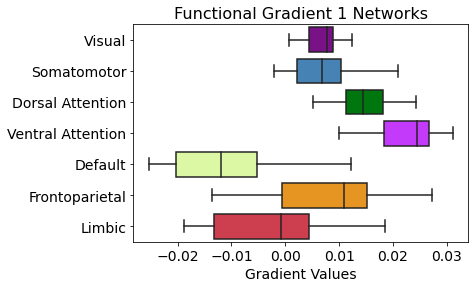

In [413]:
p = sns.boxplot(data=funcG1_net, orient='h', saturation=1, showfliers=False, palette=yeo_cols)
p.tick_params(labelsize=14)
p.axes.set_title("Functional Gradient 1 Networks", fontsize=16)
p.set_xlabel("Gradient Values", fontsize=14)
plt.savefig(fig_path + f'Func_HCPMMP_G1-Gradient-weighted_cortical_networks.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
sort_funcG1 = funcG1_net.mean().sort_values().index
sorted_funcG1 = funcG1_net[sort_funcG1]

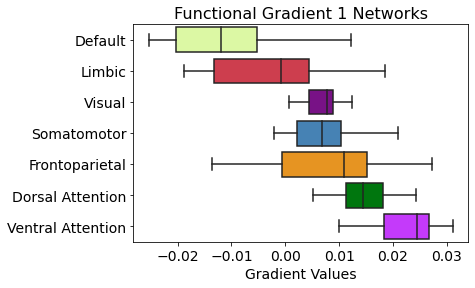

In [414]:
p = sns.boxplot(data=sorted_funcG1, orient='h', saturation=1, showfliers=False, palette=yeo_cols)
p.tick_params(labelsize=14)
p.axes.set_title("Functional Gradient 1 Networks", fontsize=16)
p.set_xlabel("Gradient Values", fontsize=14)
plt.savefig(fig_path + f'Func_HCPMMP_G1-Gradient-weighted_cortical_networks_mean-sorted.png', dpi=300, bbox_inches='tight')
plt.show()

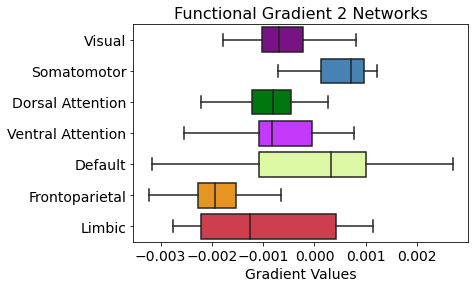

In [415]:
p = sns.boxplot(data=funcG2_net, orient='h', saturation=1, showfliers=False, palette=yeo_cols)
p.tick_params(labelsize=14)
p.axes.set_title("Functional Gradient 2 Networks", fontsize=16)
p.set_xlabel("Gradient Values", fontsize=14)
plt.savefig(fig_path + f'Func_HCPMMP_G2-Gradient-weighted_cortical_networks.png', dpi=300, bbox_inches='tight')
plt.show()

In [417]:
sort_funcG2 = funcG2_net.mean().sort_values().index
sorted_funcG2 = funcG2_net[sort_funcG2]

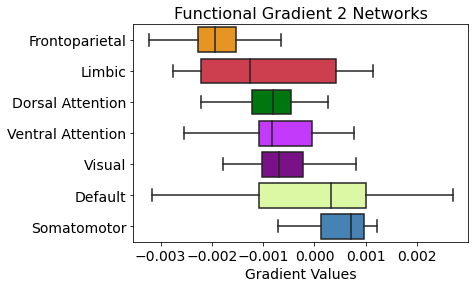

In [419]:
p = sns.boxplot(data=sorted_funcG2, orient='h', saturation=1, showfliers=False, palette=yeo_cols)
p.tick_params(labelsize=14)
p.axes.set_title("Functional Gradient 2 Networks", fontsize=16)
p.set_xlabel("Gradient Values", fontsize=14)
plt.savefig(fig_path + f'Func_HCPMMP_G2-Gradient-weighted_cortical_networks_mean-sorted.png', dpi=300, bbox_inches='tight')
plt.show()

#### Structural data

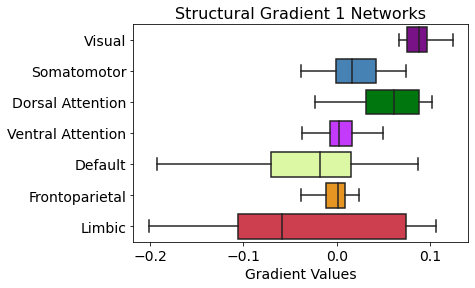

In [43]:
p = sns.boxplot(data=diffG1_net, orient='h', saturation=1, showfliers=False, palette=yeo_cols)
p.tick_params(labelsize=14)
p.axes.set_title("Structural Gradient 1 Networks", fontsize=16)
p.set_xlabel("Gradient Values", fontsize=14)
plt.savefig(fig_path + f'Diff_7Tsubj_G1-Gradient-weighted_cortical_networks.png',dpi=300, bbox_inches='tight')
plt.show()

In [44]:
sort_diffG1 = diffG1_net.mean().sort_values().index
sorted_diffG1 = diffG1_net[sort_diffG1]

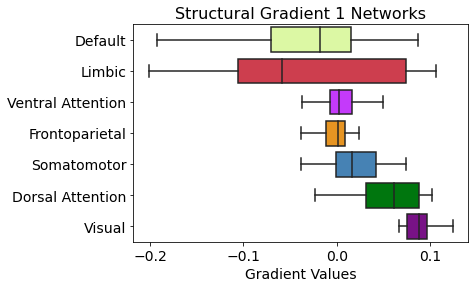

In [411]:
p = sns.boxplot(data=sorted_diffG1, orient='h', saturation=1, showfliers=False, palette=yeo_cols)
p.tick_params(labelsize=14)
p.axes.set_title("Structural Gradient 1 Networks", fontsize=16)
p.set_xlabel("Gradient Values", fontsize=14)
plt.savefig(fig_path + f'Diff_7Tsubj_G1-Gradient-weighted_cortical_networks_mean-sorted.png', dpi=300, bbox_inches='tight')
plt.show()

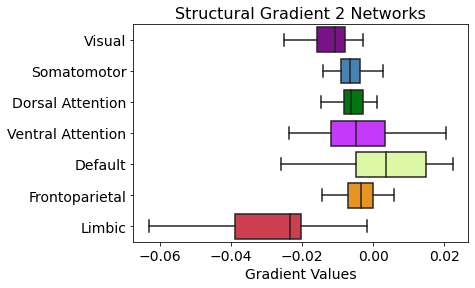

In [46]:
p = sns.boxplot(data=diffG2_net, orient='h', saturation=1, showfliers=False, palette=yeo_cols)
p.tick_params(labelsize=14)
p.axes.set_title("Structural Gradient 2 Networks", fontsize=16)
p.set_xlabel("Gradient Values", fontsize=14)
plt.savefig(fig_path + f'Diff_7Tsubj_G2-Gradient-weighted_cortical_networks.png',dpi=300, bbox_inches='tight')
plt.show()

In [409]:
sort_diffG2 = diffG2_net.mean().sort_values().index
sorted_diffG2 = diffG2_net[sort_diffG2]

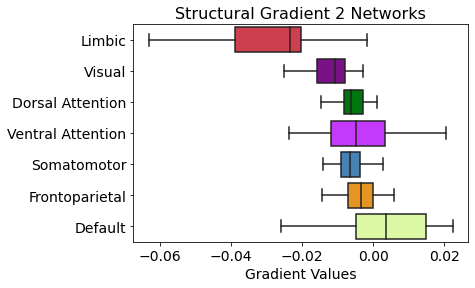

In [412]:
p = sns.boxplot(data=sorted_diffG2, orient='h', saturation=1, showfliers=False, palette=yeo_cols)
p.tick_params(labelsize=14)
p.axes.set_title("Structural Gradient 2 Networks", fontsize=16)
p.set_xlabel("Gradient Values", fontsize=14)
plt.savefig(fig_path + f'Diff_7Tsubj_G2-Gradient-weighted_cortical_networks_mean-sorted.png', dpi=300, bbox_inches='tight')
plt.show()

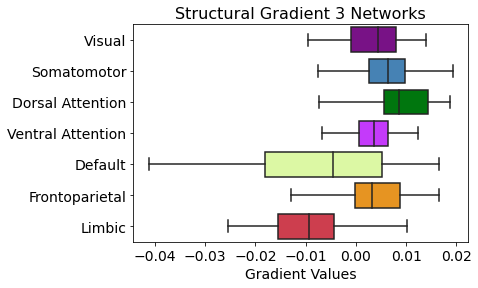

In [49]:
p = sns.boxplot(data=diffG3_net, orient='h', saturation=1, showfliers=False, palette=yeo_cols)
p.tick_params(labelsize=14)
p.axes.set_title("Structural Gradient 3 Networks", fontsize=16)
p.set_xlabel("Gradient Values", fontsize=14)
plt.savefig(fig_path + f'Diff_7Tsubj_G3-Gradient-weighted_cortical_networks.png',dpi=300, bbox_inches='tight')
plt.show()

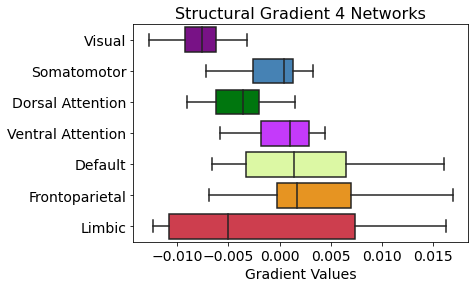

In [50]:
p = sns.boxplot(data=diffG4_net, orient='h', saturation=1, showfliers=False, palette=yeo_cols)
p.tick_params(labelsize=14)
p.axes.set_title("Structural Gradient 4 Networks", fontsize=16)
p.set_xlabel("Gradient Values", fontsize=14)
plt.savefig(fig_path + f'Diff_7Tsubj_G4-Gradient-weighted_cortical_networks.png',dpi=300, bbox_inches='tight')
plt.show()

### Plot with sns: kdeplots and histplots

#### Gradient 1 bar plot

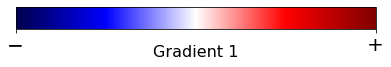

In [117]:
fig = plt.figure(figsize=(10,10))
norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='seismic'), 
                  ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Gradient 1", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['−','+'], fontsize=20)
plt.savefig(fig_path+f'Gradient1_bar.png', dpi=300, bbox_inches='tight')
plt.show()

#### Functional Data

##### Data DFs

In [19]:
funcG1_net.head(5)

,Visual,Somatomotor,Dorsal Attention,Ventral Attention,Default,Frontoparietal,Limbic
0,0.012430,0.002987,0.023383,0.005559,-0.005389,-0.004487,-0.016521
1,0.007695,-0.000472,0.023702,0.009877,-0.003734,-0.005268,-0.003320
2,0.009775,0.011242,0.000753,0.010916,-0.024482,0.004495,0.011127
3,0.007877,-0.002156,0.013131,0.016987,-0.021805,-0.013583,-0.000890
4,0.007958,0.001817,0.015157,0.019695,-0.011862,-0.001811,0.009489


In [140]:
sort_funcG1 = funcG1_net.mean().sort_values().index
sorted_funcG1 = funcG1_net[sort_funcG1]
sorted_funcG1.head(5)

,Default,Limbic,Visual,Somatomotor,Frontoparietal,Dorsal Attention,Ventral Attention
0,-0.005389,-0.016521,0.012430,0.002987,-0.004487,0.023383,0.005559
1,-0.003734,-0.003320,0.007695,-0.000472,-0.005268,0.023702,0.009877
2,-0.024482,0.011127,0.009775,0.011242,0.004495,0.000753,0.010916
3,-0.021805,-0.000890,0.007877,-0.002156,-0.013583,0.013131,0.016987
4,-0.011862,0.009489,0.007958,0.001817,-0.001811,0.015157,0.019695


In [40]:
funcG1_melt_net = pd.melt(funcG1_net, var_name='Networks', value_name='Gradients')
funcG1_melt_net.head(5)

,Networks,Gradients
0,Visual,0.012430
1,Visual,0.007695
2,Visual,0.009775
3,Visual,0.007877
4,Visual,0.007958


In [141]:
sorted_funcG1_melt = pd.melt(sorted_funcG1, var_name='Networks', value_name='Gradients')
sorted_funcG1_melt.head(5)

,Networks,Gradients
0,Default,-0.005389
1,Default,-0.003734
2,Default,-0.024482
3,Default,-0.021805
4,Default,-0.011862


##### KDE plots

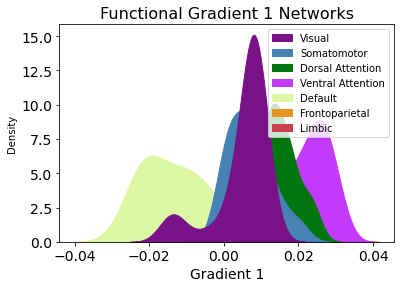

In [147]:
p = sns.kdeplot(data=funcG1_net, fill=True, palette=yeo_cols, alpha=1)
p.tick_params(labelsize=14)
p.axes.set_title("Functional Gradient 1 Networks", fontsize=16)
p.set_xlabel("Gradient 1", fontsize=14)
#plt.savefig(fig_path + f'Func_HCPMMP_G1-Gradient-weighted_cortical_networks.png', dpi=300, bbox_inches='tight')
plt.show()

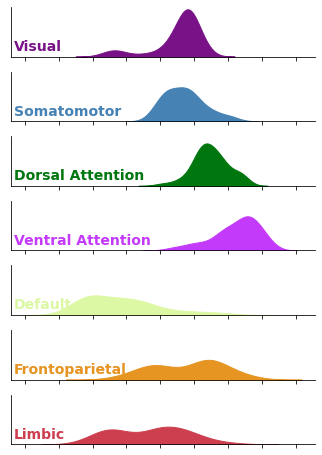

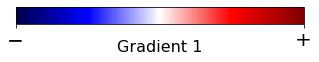

In [149]:
g = sns.FacetGrid(funcG1_melt_net, row="Networks", hue="Networks", aspect=5, height=1, palette=yeo_cols)
g.map(sns.kdeplot,"Gradients", fill=True, alpha=1)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0.01, .2, label, fontweight="bold", color=color,
            ha="left", va="center", fontsize=14, transform=ax.transAxes)
g.map(label, "Gradients")

g.set_titles("")
g.set(yticklabels=[], yticks=[], ylabel="", xlabel="", xticklabels=[])
g.figure.subplots_adjust(hspace=0.3)

g.savefig(fig_path+f'Func_HCPMMP_G1-weighted_cortical_networks_Facet-kdes.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(8,8))
norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='seismic'), 
                  ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Gradient 1", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['−','+'], fontsize=20)
plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:156: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


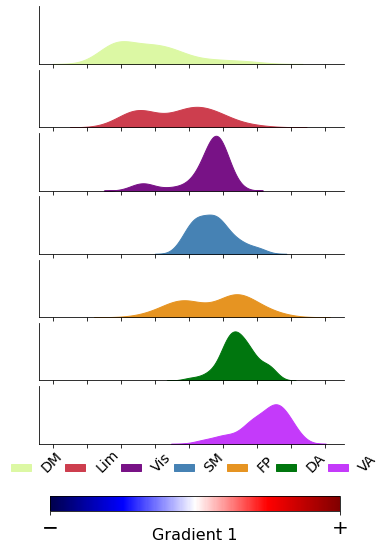

In [295]:
g = sns.FacetGrid(sorted_funcG1_melt, row="Networks", hue="Networks", aspect=5, height=1, palette=yeo_cols)
g.map(sns.kdeplot,"Gradients", fill=True, alpha=1)

hue_labels = ['DM','Lim','Vis','SM','FP','DA','VA']
g.add_legend(labels=hue_labels)
sns.move_legend(
    g, "center",
    bbox_to_anchor=(0.5, 0.05), ncol=7, title=None, borderaxespad=0,
    columnspacing=0
)
for text in g.legend.texts:
    text.set_fontsize(14)
    text.set_rotation(45)

g.set_titles("")
g.set(yticklabels=[], yticks=[], ylabel="", xlabel="", xticklabels=[])
g.figure.subplots_adjust(hspace=0.1)

norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = g.fig.add_axes([0.15, -.05, 0.7, 0.03]) # start x, start y, length x, height y
cb = g.fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='seismic'), 
                    ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Gradient 1", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['−','+'], fontsize=20)

g.savefig(fig_path+f'Func_HCPMMP_G1-weighted_cortical_networks_Facet-kdes_Mean-sorted_blabel.png', dpi=300, bbox_inches='tight')

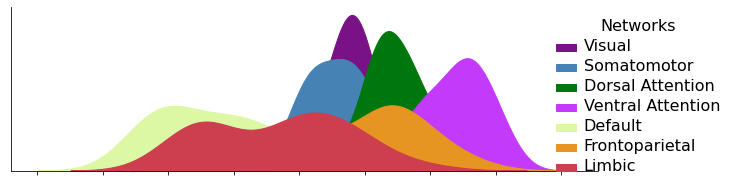

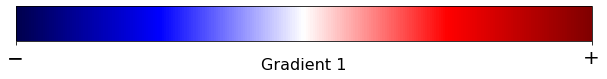

In [189]:
g = sns.FacetGrid(funcG1_melt_net, hue="Networks", aspect=3, height=3, palette=yeo_cols)
g.map(sns.kdeplot,"Gradients", fill=True, alpha=1)
g.add_legend()
g.legend.get_title().set_fontsize(16)
for text in g.legend.texts:
    text.set_fontsize(16)

g.set_titles("")
g.set(yticklabels=[], yticks=[], ylabel="", xlabel="", xticklabels=[])
g.figure.subplots_adjust(hspace=0.3)

g.savefig(fig_path+f'Func_HCPMMP_G1-weighted_cortical_networks_Kde.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(16,16))
norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='seismic'), 
                  ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Gradient 1", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['−','+'], fontsize=20)
plt.show()

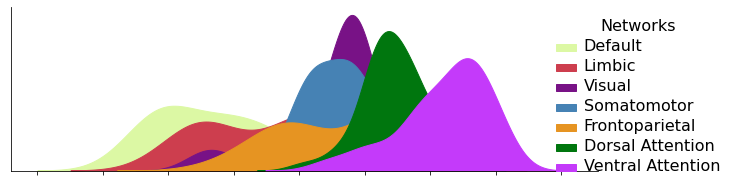

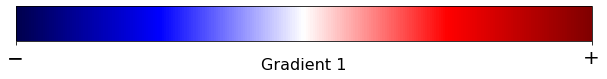

In [152]:
g = sns.FacetGrid(sorted_funcG1_melt, hue="Networks", aspect=3, height=3, palette=yeo_cols)
g.map(sns.kdeplot,"Gradients", fill=True, alpha=1)
g.add_legend()
g.legend.get_title().set_fontsize(16)
for text in g.legend.texts:
    text.set_fontsize(16)

g.set_titles("")
g.set(yticklabels=[], yticks=[], ylabel="", xlabel="", xticklabels=[])
g.figure.subplots_adjust(hspace=0.3)

g.savefig(fig_path+f'Func_HCPMMP_G1-weighted_cortical_networks_Kdes_Mean-sorted.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(16,16))
norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='seismic'), 
                  ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Gradient 1", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['−','+'], fontsize=20)
plt.show()

##### HistPlots

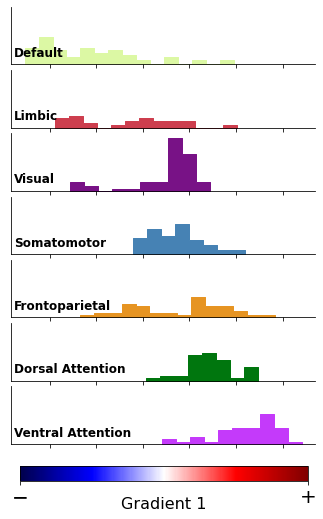

In [379]:
g = sns.FacetGrid(sorted_funcG1_melt, row="Networks", hue="Networks", aspect=5, height=1, palette=yeo_cols)
g.map(sns.histplot,"Gradients", element="step",fill=True, alpha=1, common_bins=True, binwidth=0.003)
g.set(ylim=(0, 25))

def label(x, color, label):
    ax = plt.gca()
    ax.text(0.01, .2, label, fontweight="bold",
            ha="left", va="center", fontsize=12, transform=ax.transAxes)
g.map(label, "Gradients")
g.set_titles("")
g.set(yticklabels=[], yticks=[], ylabel="", xlabel="", xticklabels=[])
g.figure.subplots_adjust(hspace=0.1)

norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = g.fig.add_axes([0.15, 0.01, 0.8, 0.03]) # start x, start y, length x, height y
cb = g.fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='seismic'), ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Gradient 1", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['−','+'], fontsize=20)

g.savefig(fig_path+f'Func_HCPMMP_G1-weighted_cortical_networks_Facet-hist-step_Mean-sorted.png', dpi=300, bbox_inches='tight')

#### Structural Data

##### Data DFs

In [153]:
diffG1_net.head(5)

,Visual,Somatomotor,Dorsal Attention,Ventral Attention,Default,Frontoparietal,Limbic
0,0.096945,-0.006741,-0.023705,-0.017566,-0.023924,0.055088,-0.106317
1,0.042232,0.027682,-0.005627,0.032352,0.015262,0.075605,-0.071947
2,0.102752,0.016094,0.035422,0.029706,-0.029695,-0.016537,-0.058401
3,0.089521,0.038716,0.084221,0.049748,0.020283,-0.004884,-0.145429
4,0.103112,0.073857,0.099652,-0.049187,-0.161078,-0.002066,-0.070429


In [154]:
sort_diffG1 = diffG1_net.mean().sort_values().index
sorted_diffG1 = diffG1_net[sort_diffG1]
sorted_diffG1.head(5)

,Default,Limbic,Ventral Attention,Frontoparietal,Somatomotor,Dorsal Attention,Visual
0,-0.023924,-0.106317,-0.017566,0.055088,-0.006741,-0.023705,0.096945
1,0.015262,-0.071947,0.032352,0.075605,0.027682,-0.005627,0.042232
2,-0.029695,-0.058401,0.029706,-0.016537,0.016094,0.035422,0.102752
3,0.020283,-0.145429,0.049748,-0.004884,0.038716,0.084221,0.089521
4,-0.161078,-0.070429,-0.049187,-0.002066,0.073857,0.099652,0.103112


In [155]:
diffG1_melt_net = pd.melt(diffG1_net, var_name='Networks', value_name='Gradients')
diffG1_melt_net.head(5)

,Networks,Gradients
0,Visual,0.096945
1,Visual,0.042232
2,Visual,0.102752
3,Visual,0.089521
4,Visual,0.103112


In [156]:
sorted_diffG1_melt = pd.melt(sorted_diffG1, var_name='Networks', value_name='Gradients')
sorted_diffG1_melt.head(5)

,Networks,Gradients
0,Default,-0.023924
1,Default,0.015262
2,Default,-0.029695
3,Default,0.020283
4,Default,-0.161078


##### KDE plots

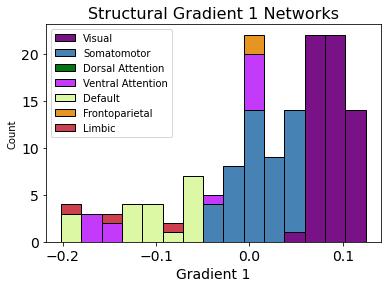

In [323]:
p = sns.histplot(data=diffG1_net, fill=True, palette=yeo_cols, alpha=1)
p.tick_params(labelsize=14)
p.axes.set_title("Structural Gradient 1 Networks", fontsize=16)
p.set_xlabel("Gradient 1", fontsize=14)
#plt.savefig(fig_path + f'diff_HCPMMP_G1-Gradient-weighted_cortical_networks.png', dpi=300, bbox_inches='tight')
plt.show()

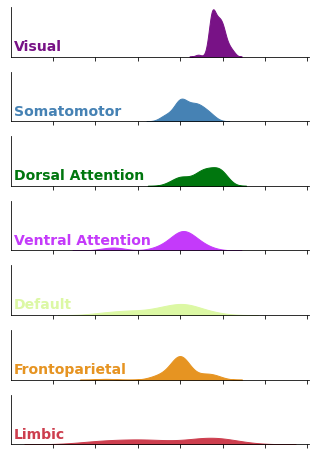

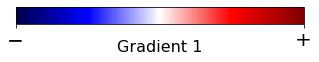

In [158]:
g = sns.FacetGrid(diffG1_melt_net, row="Networks", hue="Networks", aspect=5, height=1, palette=yeo_cols)
g.map(sns.kdeplot,"Gradients", fill=True, alpha=1)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0.01, .2, label, fontweight="bold", color=color,
            ha="left", va="center", fontsize=14, transform=ax.transAxes)
g.map(label, "Gradients")

g.set_titles("")
g.set(yticklabels=[], yticks=[], ylabel="", xlabel="", xticklabels=[])
g.figure.subplots_adjust(hspace=0.3)

g.savefig(fig_path+f'Diff_7Tsubj_G1-weighted_cortical_networks_Facet-kdes.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(8,8))
norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='seismic'), 
                  ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Gradient 1", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['−','+'], fontsize=20)
plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:156: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


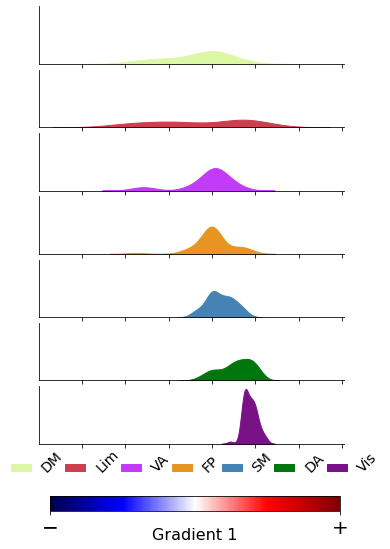

In [273]:
g = sns.FacetGrid(sorted_diffG1_melt, row="Networks", hue="Networks", aspect=5, height=1, palette=yeo_cols)
g.map(sns.kdeplot,"Gradients", fill=True, alpha=1)

hue_labels = ['DM','Lim','VA','FP','SM','DA','Vis']
g.add_legend(labels=hue_labels)
sns.move_legend(
    g, "center",
    bbox_to_anchor=(0.5, 0.05), ncol=7, title=None, borderaxespad=0,
    columnspacing=0
)
for text in g.legend.texts:
    text.set_fontsize(14)
    text.set_rotation(45)
g.set_titles("")
g.set(yticklabels=[], yticks=[], ylabel="", xlabel="", xticklabels=[])
g.figure.subplots_adjust(hspace=0.1)

norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = g.fig.add_axes([0.15, -.05, 0.7, 0.03]) # start x, start y, length x, height y
cb = g.fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='seismic'), 
                    ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Gradient 1", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['−','+'], fontsize=20)

g.savefig(fig_path+f'Diff_7Tsubj_G1-weighted_cortical_networks_Facet-kdes_Mean-sorted_blabel.png', dpi=300, bbox_inches='tight')

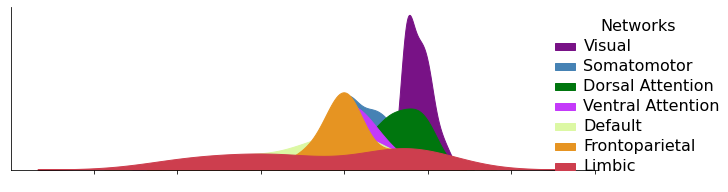

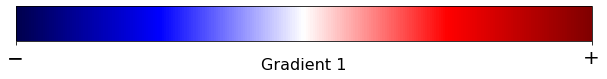

In [160]:
g = sns.FacetGrid(diffG1_melt_net, hue="Networks", aspect=3, height=3, palette=yeo_cols)
g.map(sns.kdeplot,"Gradients", fill=True, alpha=1)
g.add_legend()
g.legend.get_title().set_fontsize(16)
for text in g.legend.texts:
    text.set_fontsize(16)

g.set_titles("")
g.set(yticklabels=[], yticks=[], ylabel="", xlabel="", xticklabels=[])
g.figure.subplots_adjust(hspace=0.3)

g.savefig(fig_path+f'Diff_7Tsubj_G1-weighted_cortical_networks_Kde.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(16,16))
norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='seismic'), 
                  ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Gradient 1", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['−','+'], fontsize=20)
plt.show()

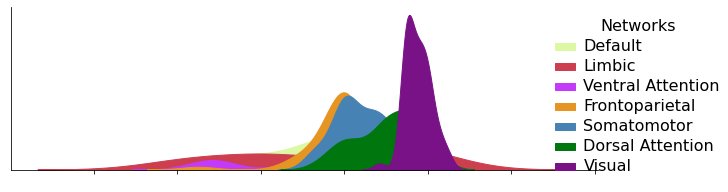

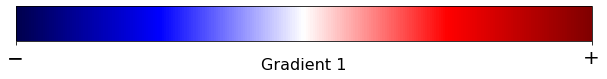

In [161]:
g = sns.FacetGrid(sorted_diffG1_melt, hue="Networks", aspect=3, height=3, palette=yeo_cols)
g.map(sns.kdeplot,"Gradients", fill=True, alpha=1)
g.add_legend()
g.legend.get_title().set_fontsize(16)
for text in g.legend.texts:
    text.set_fontsize(16)

g.set_titles("")
g.set(yticklabels=[], yticks=[], ylabel="", xlabel="", xticklabels=[])
g.figure.subplots_adjust(hspace=0.3)

g.savefig(fig_path+f'Diff_7Tsubj_G1-weighted_cortical_networks_Kdes_Mean-sorted.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(16,16))
norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='seismic'), 
                  ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Gradient 1", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['−','+'], fontsize=20)
plt.show()

##### HistPlot

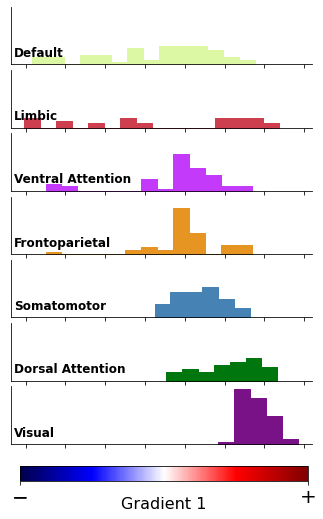

In [381]:
g = sns.FacetGrid(sorted_diffG1_melt, row="Networks", hue="Networks", aspect=5, height=1, palette=yeo_cols)
g.map(sns.histplot,"Gradients", element="step", fill=True, alpha=1, common_bins=True, binwidth=0.02)
g.set(ylim=(0, 25))

def label(x, color, label):
    ax = plt.gca()
    ax.text(0.01, .2, label, fontweight="bold",
            ha="left", va="center", fontsize=12, transform=ax.transAxes)
g.map(label, "Gradients")

g.set_titles("")
g.set(yticklabels=[], yticks=[], ylabel="", xlabel="", xticklabels=[])
g.figure.subplots_adjust(hspace=0.1)

norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = g.fig.add_axes([0.15, 0.01, 0.8, 0.03]) # start x, start y, length x, height y
cb = g.fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='seismic'), 
                    ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Gradient 1", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['−','+'], fontsize=20)

g.savefig(fig_path+f'Diff_7Tsubj_G1-weighted_cortical_networks_Facet-hist-step_Mean-sorted.png', dpi=300, bbox_inches='tight')

### Statistical test

#### calculate null maps

In [384]:
# get the cortical data
Func_GCtx = np.load(Func_results + 'Func_HCPMMP_Gradient-weighted_CorticalConnectivity.npz')
func_g1 = pd.DataFrame(Func_GCtx['G1_Ctx'])
func_g2 = pd.DataFrame(Func_GCtx['G2_Ctx'])

In [385]:
Diff_GCtx = np.load(Diff_results + 'Diff_7Tsubj_Gradient-weighted_CorticalConnectivity.npz')
diff_g1 = pd.DataFrame(Diff_GCtx['G1_Ctx'])
diff_g2 = pd.DataFrame(Diff_GCtx['G2_Ctx'])

In [71]:
Fuse_GCtx = np.load(Fuse_results + 'Fused-matrix_Gradient-weighted_CorticalConnectivity.npz')
fuse_g1 = pd.DataFrame(Fuse_GCtx['G1_Ctx'])
fuse_g2 = pd.DataFrame(Fuse_GCtx['G2_Ctx'])
fuse_g3 = pd.DataFrame(Fuse_GCtx['G3_Ctx'])

In [386]:
func_g1_ctx = np.nanmean(func_g1.to_numpy(),axis=0).reshape([360])
func_g2_ctx = np.nanmean(func_g2.to_numpy(),axis=0).reshape([360])

In [387]:
diff_g1_ctx = np.nanmean(diff_g1.to_numpy(),axis=0).reshape([360])
diff_g2_ctx = np.nanmean(diff_g2.to_numpy(),axis=0).reshape([360])

In [74]:
fuse_g1_ctx = np.nanmean(fuse_g1.to_numpy(),axis=0).reshape([360])
fuse_g2_ctx = np.nanmean(fuse_g2.to_numpy(),axis=0).reshape([360])
fuse_g3_ctx = np.nanmean(fuse_g3.to_numpy(),axis=0).reshape([360])

In [75]:
# preparing parcellation for null maps calculation
# load the hcp-mmp1 parcellation gii file
hcpmmp_lh = images.load_gifti(data_path + 'glasser_360_fsaverage5_lhlabel.gii')
hcpmmp_rh = images.load_gifti(data_path + 'glasser_360_fsaverage5_rhlabel.gii')
# combine lh and rh (and make the labels order consecutive)
hcpmmp_parcellation = images.relabel_gifti((hcpmmp_lh, hcpmmp_rh))

In [76]:
from neuromaps import parcellate
# create parcellater
hcpmmp = parcellate.Parcellater(hcpmmp_parcellation, 'fsaverage').fit()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [77]:
n_perm = 10000

In [78]:
from neuromaps import nulls
func_g1_rotated = nulls.alexander_bloch(func_g1_ctx, atlas='fsaverage', density='10k',
                                        n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [79]:
func_g2_rotated = nulls.alexander_bloch(func_g2_ctx, atlas='fsaverage', density='10k',
                                        n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [80]:
diff_g1_rotated = nulls.alexander_bloch(diff_g1_ctx, atlas='fsaverage', density='10k',
                                        n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [81]:
diff_g2_rotated = nulls.alexander_bloch(diff_g2_ctx, atlas='fsaverage', density='10k',
                                        n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [82]:
fuse_g1_rotated = nulls.alexander_bloch(fuse_g1_ctx, atlas='fsaverage', density='10k',
                                        n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [83]:
fuse_g2_rotated = nulls.alexander_bloch(fuse_g2_ctx, atlas='fsaverage', density='10k',
                                        n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [84]:
fuse_g3_rotated = nulls.alexander_bloch(fuse_g3_ctx, atlas='fsaverage', density='10k',
                                        n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [85]:
pd.DataFrame(func_g1_rotated).to_csv(results_path + f'Func_HCPMMP_G1_alex-rotated_N-perm'+str(n_perm)+'_data.csv', index = False)

In [86]:
pd.DataFrame(func_g2_rotated).to_csv(results_path + f'Func_HCPMMP_G2_alex-rotated_N-perm'+str(n_perm)+'_data.csv', index = False)

In [87]:
pd.DataFrame(diff_g1_rotated).to_csv(results_path + f'Diff_7Tsubj_G1_alex-rotated_N-perm'+str(n_perm)+'_data.csv', index = False)

In [88]:
pd.DataFrame(diff_g2_rotated).to_csv(results_path + f'Diff_7Tsubj_G2_alex-rotated_N-perm'+str(n_perm)+'_data.csv', index = False)

In [89]:
pd.DataFrame(fuse_g1_rotated).to_csv(results_path + f'Fused-matrix_G1_alex-rotated_N-perm'+str(n_perm)+'_data.csv', index = False)

In [90]:
pd.DataFrame(fuse_g2_rotated).to_csv(results_path + f'Fused-matrix_G2_alex-rotated_N-perm'+str(n_perm)+'_data.csv', index = False)

In [91]:
pd.DataFrame(fuse_g3_rotated).to_csv(results_path + f'Fused-matrix_G3_alex-rotated_N-perm'+str(n_perm)+'_data.csv', index = False)

In [96]:
func_g1_rotated = pd.read_csv(results_path + f'Func_HCPMMP_G1_alex-rotated_N-perm'+str(n_perm)+'_data.csv').to_numpy()
func_g2_rotated = pd.read_csv(results_path + f'Func_HCPMMP_G2_alex-rotated_N-perm'+str(n_perm)+'_data.csv').to_numpy()

In [97]:
diff_g1_rotated = pd.read_csv(results_path + f'Diff_7Tsubj_G1_alex-rotated_N-perm'+str(n_perm)+'_data.csv').to_numpy()
diff_g2_rotated = pd.read_csv(results_path + f'Diff_7Tsubj_G2_alex-rotated_N-perm'+str(n_perm)+'_data.csv').to_numpy()

In [98]:
fuse_g1_rotated = pd.read_csv(results_path + f'Fused-matrix_G1_alex-rotated_N-perm'+str(n_perm)+'_data.csv').to_numpy()
fuse_g2_rotated = pd.read_csv(results_path + f'Fused-matrix_G2_alex-rotated_N-perm'+str(n_perm)+'_data.csv').to_numpy()
fuse_g3_rotated = pd.read_csv(results_path + f'Fused-matrix_G3_alex-rotated_N-perm'+str(n_perm)+'_data.csv').to_numpy()

#### repeat network the ANOVA for rotated data

In [383]:
# getting network data
labels_txt = pd.read_csv(data_path+'hcp_mmp10_yeo7_modes.txt',header=None)
labels_txt[['Label','Hemisphere','Area','ROI','Network#','Network']]= labels_txt[0].str.split('_',expand=True)
networks = labels_txt['Network'].unique()

In [100]:
n_times = np.arange(0, n_perm, 1)

In [101]:
fG1N_net = {}
for i in n_times:
    fG1N_net[i] = pd.DataFrame()
    for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con = func_g1_rotated[:,i].T[net_inds]
        fG1N_net[i][str(nets)] = pd.Series(net_con)

In [102]:
fG2N_net = {}
for i in n_times:
    fG2N_net[i] = pd.DataFrame()
    for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con = func_g2_rotated[:,i].T[net_inds]
        fG2N_net[i][str(nets)] = pd.Series(net_con)

In [103]:
sG1N_net = {}
for i in n_times:
    sG1N_net[i] = pd.DataFrame()
    for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con = diff_g1_rotated[:,i].T[net_inds]
        sG1N_net[i][str(nets)] = pd.Series(net_con)

In [104]:
sG2N_net = {}
for i in n_times:
    sG2N_net[i] = pd.DataFrame()
    for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con = diff_g2_rotated[:,i].T[net_inds]
        sG2N_net[i][str(nets)] = pd.Series(net_con)

In [105]:
fsG1N_net = {}
for i in n_times:
    fsG1N_net[i] = pd.DataFrame()
    for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con = fuse_g1_rotated[:,i].T[net_inds]
        fsG1N_net[i][str(nets)] = pd.Series(net_con)

In [106]:
fsG2N_net = {}
for i in n_times:
    fsG2N_net[i] = pd.DataFrame()
    for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con = fuse_g2_rotated[:,i].T[net_inds]
        fsG2N_net[i][str(nets)] = pd.Series(net_con)

In [107]:
fsG3N_net = {}
for i in n_times:
    fsG3N_net[i] = pd.DataFrame()
    for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con = fuse_g3_rotated[:,i].T[net_inds]
        fsG3N_net[i][str(nets)] = pd.Series(net_con)

In [108]:
fG1N_melt_net = {}
for i in n_times:
    fG1N_melt_net[i] = pd.melt(fG1N_net[i], var_name='Networks', value_name='Gradients')

In [109]:
fG2N_melt_net = {}
for i in n_times:
    fG2N_melt_net[i] = pd.melt(fG2N_net[i], var_name='Networks', value_name='Gradients')

In [110]:
sG1N_melt_net = {}
for i in n_times:
    sG1N_melt_net[i] = pd.melt(sG1N_net[i], var_name='Networks', value_name='Gradients')

In [111]:
sG2N_melt_net = {}
for i in n_times:
    sG2N_melt_net[i] = pd.melt(sG2N_net[i], var_name='Networks', value_name='Gradients')

In [112]:
fsG1N_melt_net = {}
for i in n_times:
    fsG1N_melt_net[i] = pd.melt(fsG1N_net[i], var_name='Networks', value_name='Gradients')

In [113]:
fsG2N_melt_net = {}
for i in n_times:
    fsG2N_melt_net[i] = pd.melt(fsG2N_net[i], var_name='Networks', value_name='Gradients')

In [114]:
fsG3N_melt_net = {}
for i in n_times:
    fsG3N_melt_net[i] = pd.melt(fsG3N_net[i], var_name='Networks', value_name='Gradients')

In [115]:
import pingouin as pg
aov = {}
funcG1_Naov = pd.DataFrame(columns = ['Source', 'ddof1', 'ddof2', 'F', 'p-unc', 'np2'], dtype='object')
for i in n_times:
    aov[i] = pg.anova(data=fG1N_melt_net[i], dv='Gradients', between='Networks')
    funcG1_Naov = pd.concat([funcG1_Naov, aov[i]], names=i)

In [116]:
import pingouin as pg
aov = {}
funcG2_Naov = pd.DataFrame(columns = ['Source', 'ddof1', 'ddof2', 'F', 'p-unc', 'np2'], dtype='object')
for i in n_times:
    aov[i] = pg.anova(data=fG2N_melt_net[i], dv='Gradients', between='Networks')
    funcG2_Naov = pd.concat([funcG2_Naov, aov[i]], names=i)

In [117]:
import pingouin as pg
aov = {}
diffG1_Naov = pd.DataFrame(columns = ['Source', 'ddof1', 'ddof2', 'F', 'p-unc', 'np2'], dtype='object')
for i in n_times:
    aov[i] = pg.anova(data=sG1N_melt_net[i], dv='Gradients', between='Networks')
    diffG1_Naov = pd.concat([diffG1_Naov, aov[i]], names=i)

In [118]:
import pingouin as pg
aov = {}
diffG2_Naov = pd.DataFrame(columns = ['Source', 'ddof1', 'ddof2', 'F', 'p-unc', 'np2'], dtype='object')
for i in n_times:
    aov[i] = pg.anova(data=sG2N_melt_net[i], dv='Gradients', between='Networks')
    diffG2_Naov = pd.concat([diffG2_Naov, aov[i]], names=i)

In [119]:
aov = {}
fuseG1_Naov = pd.DataFrame(columns = ['Source', 'ddof1', 'ddof2', 'F', 'p-unc', 'np2'], dtype='object')
for i in n_times:
    aov[i] = pg.anova(data=fsG1N_melt_net[i], dv='Gradients', between='Networks')
    fuseG1_Naov = pd.concat([fuseG1_Naov, aov[i]], names=i)

In [120]:
aov = {}
fuseG2_Naov = pd.DataFrame(columns = ['Source', 'ddof1', 'ddof2', 'F', 'p-unc', 'np2'], dtype='object')
for i in n_times:
    aov[i] = pg.anova(data=fsG2N_melt_net[i], dv='Gradients', between='Networks')
    fuseG2_Naov = pd.concat([fuseG2_Naov, aov[i]], names=i)

In [121]:
aov = {}
fuseG3_Naov = pd.DataFrame(columns = ['Source', 'ddof1', 'ddof2', 'F', 'p-unc', 'np2'], dtype='object')
for i in n_times:
    aov[i] = pg.anova(data=fsG3N_melt_net[i], dv='Gradients', between='Networks')
    fuseG3_Naov = pd.concat([fuseG3_Naov, aov[i]], names=i)

#### calculate empirical and p_perm

In [388]:
funcG1_emp = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con = func_g1_ctx[net_inds]
    funcG1_emp[str(nets)] = pd.Series(net_con)

In [389]:
funcG2_emp = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con = func_g2_ctx[net_inds]
    funcG2_emp[str(nets)] = pd.Series(net_con)

In [390]:
diffG1_emp = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con = diff_g1_ctx[net_inds]
    diffG1_emp[str(nets)] = pd.Series(net_con)

In [391]:
diffG2_emp = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con = diff_g2_ctx[net_inds]
    diffG2_emp[str(nets)] = pd.Series(net_con)

In [126]:
fuseG1_emp = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con = fuse_g1_ctx[net_inds]
    fuseG1_emp[str(nets)] = pd.Series(net_con)

In [127]:
fuseG2_emp = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con = fuse_g2_ctx[net_inds]
    fuseG2_emp[str(nets)] = pd.Series(net_con)

In [128]:
fuseG3_emp = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con = fuse_g3_ctx[net_inds]
    fuseG3_emp[str(nets)] = pd.Series(net_con)

In [392]:
funcG1_meltemp = pd.melt(funcG1_emp, var_name='Networks', value_name='Gradients')
funcG1_empaov = pg.anova(data=funcG1_meltemp, dv='Gradients', between='Networks')

In [393]:
funcG2_meltemp = pd.melt(funcG2_emp, var_name='Networks', value_name='Gradients')
funcG2_empaov = pg.anova(data=funcG2_meltemp, dv='Gradients', between='Networks')

In [394]:
diffG1_meltemp = pd.melt(diffG1_emp, var_name='Networks', value_name='Gradients')
diffG1_empaov = pg.anova(data=diffG1_meltemp, dv='Gradients', between='Networks')

In [395]:
diffG2_meltemp = pd.melt(diffG2_emp, var_name='Networks', value_name='Gradients')
diffG2_empaov = pg.anova(data=diffG2_meltemp, dv='Gradients', between='Networks')

In [133]:
fuseG1_meltemp = pd.melt(fuseG1_emp, var_name='Networks', value_name='Gradients')
fuseG1_empaov = pg.anova(data=fuseG1_meltemp, dv='Gradients', between='Networks')

In [134]:
fuseG2_meltemp = pd.melt(fuseG2_emp, var_name='Networks', value_name='Gradients')
fuseG2_empaov = pg.anova(data=fuseG2_meltemp, dv='Gradients', between='Networks')

In [135]:
fuseG3_meltemp = pd.melt(fuseG3_emp, var_name='Networks', value_name='Gradients')
fuseG3_empaov = pg.anova(data=fuseG3_meltemp, dv='Gradients', between='Networks')

In [136]:
funcG1_emp = funcG1_empaov['F'].values
funcG1_null = funcG1_Naov['F'].values

In [137]:
funcG2_emp = funcG2_empaov['F'].values
funcG2_null = funcG2_Naov['F'].values

In [138]:
diffG1_emp = diffG1_empaov['F'].values
diffG1_null = diffG1_Naov['F'].values

In [139]:
diffG2_emp = diffG2_empaov['F'].values
diffG2_null = diffG2_Naov['F'].values

In [140]:
fuseG1_emp = fuseG1_empaov['F'].values
fuseG1_null = fuseG1_Naov['F'].values

In [141]:
fuseG2_emp = fuseG2_empaov['F'].values
fuseG2_null = fuseG2_Naov['F'].values

In [142]:
fuseG3_emp = fuseG3_empaov['F'].values
fuseG3_null = fuseG3_Naov['F'].values

In [143]:
funcG1_pperm = (np.sum(funcG1_null > funcG1_emp).astype(int)) / n_perm
funcG1_pperm

0.0

In [144]:
funcG2_pperm = (np.sum(funcG2_null > funcG2_emp).astype(int)) / n_perm
funcG2_pperm

0.0

In [145]:
diffG1_pperm = (np.sum(diffG1_null > diffG1_emp).astype(int)) / n_perm
diffG1_pperm

0.0457

In [146]:
diffG2_pperm = (np.sum(diffG2_null > diffG2_emp).astype(int)) / n_perm
diffG2_pperm

0.0392

In [147]:
fuseG1_pperm = (np.sum(fuseG1_null > fuseG1_emp).astype(int)) / n_perm
fuseG1_pperm

0.0

In [148]:
fuseG2_pperm = (np.sum(fuseG2_null > fuseG2_emp).astype(int)) / n_perm
fuseG2_pperm

0.0002

In [149]:
fuseG3_pperm = (np.sum(fuseG3_null > fuseG3_emp).astype(int)) / n_perm
fuseG3_pperm

0.0038

#### calculate pairwise stats

In [396]:
funcG1_posthoc = pg.pairwise_tukey(data=funcG1_meltemp, dv='Gradients', between='Networks')
funcG2_posthoc = pg.pairwise_tukey(data=funcG2_meltemp, dv='Gradients', between='Networks')

In [397]:
diffG1_posthoc = pg.pairwise_tukey(data=diffG1_meltemp, dv='Gradients', between='Networks')
diffG2_posthoc = pg.pairwise_tukey(data=diffG2_meltemp, dv='Gradients', between='Networks')

In [152]:
fuseG1_posthoc = pg.pairwise_tukey(data=fuseG1_meltemp, dv='Gradients', between='Networks')
fuseG2_posthoc = pg.pairwise_tukey(data=fuseG2_meltemp, dv='Gradients', between='Networks')
fuseG3_posthoc = pg.pairwise_tukey(data=fuseG3_meltemp, dv='Gradients', between='Networks')

In [398]:
funcG1_pperm=0.001
funcG2_pperm=0.001
funcG1_posthoc_pperm = funcG1_posthoc[funcG1_posthoc['p-tukey'].values < funcG1_pperm]
funcG2_posthoc_pperm = funcG2_posthoc[funcG2_posthoc['p-tukey'].values < funcG2_pperm]

In [154]:
diffG1_posthoc_pperm = diffG1_posthoc[diffG1_posthoc['p-tukey'].values < diffG1_pperm]
diffG2_posthoc_pperm = diffG2_posthoc[diffG2_posthoc['p-tukey'].values < diffG2_pperm]

In [167]:
fuseG1_posthoc_pperm = fuseG1_posthoc[fuseG1_posthoc['p-tukey'].values < fuseG1_pperm]
fuseG2_posthoc_pperm = fuseG2_posthoc[fuseG2_posthoc['p-tukey'].values < fuseG2_pperm]
fuseG3_posthoc_pperm = fuseG3_posthoc[fuseG3_posthoc['p-tukey'].values < fuseG3_pperm]

#### print anova and pairwise stat

In [399]:
pg.print_table(funcG1_empaov, floatfmt='.6f')


ANOVA SUMMARY

Source      ddof1    ddof2          F     p-unc       np2
--------  -------  -------  ---------  --------  --------
Networks        6      330  88.205304  0.000000  0.615936



In [404]:
pg.print_table(funcG1_posthoc_pperm, floatfmt='.6f')


POST HOC TESTS

A                  B                    mean(A)    mean(B)       diff        se           T    p-tukey     hedges
-----------------  -----------------  ---------  ---------  ---------  --------  ----------  ---------  ---------
Default            Dorsal Attention   -0.011302   0.014709  -0.026011  0.001648  -15.778493   0.000000  -3.119513
Default            Frontoparietal     -0.011302   0.007854  -0.019156  0.001638  -11.695085   0.000000  -2.297602
Default            Limbic             -0.011302  -0.003255  -0.008046  0.001877   -4.287009   0.000472  -0.963730
Default            Somatomotor        -0.011302   0.006963  -0.018264  0.001566  -11.661080   0.000000  -2.191825
Default            Ventral Attention  -0.011302   0.022147  -0.033448  0.001609  -20.792662   0.000000  -4.012681
Default            Visual             -0.011302   0.005031  -0.016333  0.001524  -10.718931   0.000000  -1.960728
Dorsal Attention   Limbic              0.014709  -0.003255   0.017964  

In [401]:
pg.print_table(funcG2_empaov, floatfmt='.6f')


ANOVA SUMMARY

Source      ddof1    ddof2          F     p-unc       np2
--------  -------  -------  ---------  --------  --------
Networks        6      330  32.830638  0.000000  0.373795



In [405]:
pg.print_table(funcG2_posthoc_pperm, floatfmt='.6f')


POST HOC TESTS

A                 B                    mean(A)    mean(B)       diff        se           T    p-tukey     hedges
----------------  -----------------  ---------  ---------  ---------  --------  ----------  ---------  ---------
Default           Dorsal Attention    0.000023  -0.000887   0.000911  0.000183    4.989825   0.000020   0.986522
Default           Frontoparietal      0.000023  -0.001811   0.001835  0.000181   10.118039   0.000000   1.987777
Default           Limbic              0.000023  -0.000993   0.001016  0.000208    4.890752   0.000032   1.099453
Dorsal Attention  Frontoparietal     -0.000887  -0.001811   0.000924  0.000194    4.757339   0.000060   0.999897
Dorsal Attention  Somatomotor        -0.000887   0.000543  -0.001430  0.000187   -7.654334   0.000000  -1.548737
Frontoparietal    Somatomotor        -0.001811   0.000543  -0.002355  0.000186  -12.676970   0.000000  -2.549583
Frontoparietal    Ventral Attention  -0.001811  -0.000639  -0.001172  0.000190 

In [172]:
pg.print_table(diffG1_posthoc_pperm, floatfmt='.6f')


POST HOC TESTS

A                  B                    mean(A)    mean(B)       diff        se           T    p-tukey     hedges
-----------------  -----------------  ---------  ---------  ---------  --------  ----------  ---------  ---------
Default            Dorsal Attention   -0.033827   0.054464  -0.088290  0.010940   -8.070254   0.000000  -1.595543
Default            Frontoparietal     -0.033827   0.002555  -0.036381  0.010870   -3.346834   0.015756  -0.657515
Default            Somatomotor        -0.033827   0.019055  -0.052881  0.010395   -5.087440   0.000013  -0.956239
Default            Visual             -0.033827   0.087829  -0.121656  0.010112  -12.030511   0.000000  -2.200645
Dorsal Attention   Frontoparietal      0.054464   0.002555   0.051909  0.011645    4.457803   0.000228   0.936941
Dorsal Attention   Limbic              0.054464  -0.027575   0.082038  0.013137    6.244855   0.000000   1.477849
Dorsal Attention   Somatomotor         0.054464   0.019055   0.035409  

In [173]:
pg.print_table(diffG2_posthoc_pperm, floatfmt='.6f')


POST HOC TESTS

A                  B                    mean(A)    mean(B)       diff        se          T    p-tukey     hedges
-----------------  -----------------  ---------  ---------  ---------  --------  ---------  ---------  ---------
Default            Dorsal Attention    0.004262  -0.005595   0.009857  0.002053   4.800350   0.000049   0.949061
Default            Frontoparietal      0.004262  -0.003131   0.007393  0.002040   3.623451   0.006154   0.711859
Default            Limbic              0.004262  -0.026663   0.030926  0.002338  13.227475   0.000000   2.973569
Default            Somatomotor         0.004262  -0.005319   0.009581  0.001951   4.910867   0.000029   0.923050
Default            Ventral Attention   0.004262  -0.005588   0.009850  0.002004   4.915412   0.000029   0.948603
Default            Visual              0.004262  -0.012711   0.016974  0.001898   8.942539   0.000000   1.635787
Dorsal Attention   Limbic             -0.005595  -0.026663   0.021068  0.002466

In [174]:
pg.print_table(fuseG1_empaov, floatfmt='.6f')


ANOVA SUMMARY

Source      ddof1    ddof2          F     p-unc       np2
--------  -------  -------  ---------  --------  --------
Networks        6      330  72.308684  0.000000  0.567979



In [175]:
pg.print_table(fuseG1_posthoc, floatfmt='.6f')


POST HOC TESTS

A                  B                       mean(A)      mean(B)          diff          se           T    p-tukey     hedges
-----------------  -----------------  ------------  -----------  ------------  ----------  ----------  ---------  ---------
Default            Dorsal Attention   -2946.487947  3636.959541  -6583.447488  470.398605  -13.995466   0.000000  -2.766996
Default            Frontoparietal     -2946.487947  2112.269028  -5058.756975  467.395110  -10.823299   0.000000  -2.126332
Default            Limbic             -2946.487947  -690.737153  -2255.750795  535.569811   -4.211871   0.000645  -0.946839
Default            Somatomotor        -2946.487947  1857.420905  -4803.908853  446.935475  -10.748551   0.000000  -2.020305
Default            Ventral Attention  -2946.487947  5724.029129  -8670.517076  459.034177  -18.888609   0.000000  -3.645227
Default            Visual             -2946.487947   726.971096  -3673.459043  434.799213   -8.448633   0.000000  -

In [176]:
pg.print_table(fuseG2_posthoc_pperm, floatfmt='.6f')


POST HOC TESTS

A                  B                      mean(A)      mean(B)          diff          se           T    p-tukey     hedges
-----------------  -----------------  -----------  -----------  ------------  ----------  ----------  ---------  ---------
Default            Dorsal Attention   -578.464120   947.476612  -1525.940732  110.367400  -13.826010   0.000000  -2.733494
Default            Somatomotor        -578.464120   591.947210  -1170.411330  104.862356  -11.161406   0.000000  -2.097906
Default            Ventral Attention  -578.464120   178.709765   -757.173885  107.701018   -7.030332   0.000000  -1.356752
Default            Visual             -578.464120   685.845336  -1264.309456  102.014883  -12.393382   0.000000  -2.267022
Dorsal Attention   Frontoparietal      947.476612  -234.889448   1182.366060  117.472700   10.065028   0.000000   2.115468
Dorsal Attention   Limbic              947.476612  -694.768271   1642.244884  132.528913   12.391597   0.000000   2.932479

In [177]:
pg.print_table(fuseG3_posthoc_pperm, floatfmt='.6f')


POST HOC TESTS

A                  B                      mean(A)      mean(B)          diff          se           T    p-tukey     hedges
-----------------  -----------------  -----------  -----------  ------------  ----------  ----------  ---------  ---------
Default            Dorsal Attention   -350.733777  1049.200589  -1399.934366  110.953574  -12.617299   0.000000  -2.494523
Default            Frontoparietal     -350.733777   421.448492   -772.182268  110.245135   -7.004230   0.000000  -1.376042
Default            Somatomotor        -350.733777   531.298539   -882.032316  105.419293   -8.366897   0.000000  -1.572648
Default            Ventral Attention  -350.733777   486.568985   -837.302762  108.273030   -7.733253   0.000000  -1.492405
Default            Visual             -350.733777  1251.612674  -1602.346451  102.556696  -15.624006   0.000000  -2.857974
Dorsal Attention   Frontoparietal     1049.200589   421.448492    627.752097  118.096611    5.315581   0.000004   1.117229

### Fused data

In [51]:
# getting fused cortical data
Fuse_GCtx.files

['G1_Ctx', 'G2_Ctx', 'G3_Ctx', 'G4_Ctx', 'G5_Ctx', 'G6_Ctx']

In [52]:
fuse_g1 = pd.DataFrame(Fuse_GCtx['G1_Ctx'])
fuse_g2 = pd.DataFrame(Fuse_GCtx['G2_Ctx'])
fuse_g3 = pd.DataFrame(Fuse_GCtx['G3_Ctx'])

In [53]:
net_mean = []
fuseG1_net = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con_df = fuse_g1.iloc[:,net_inds]
    net_mean = net_con_df.mean()
    fuseG1_net[str(nets)] = pd.Series(net_mean.values)

In [54]:
net_mean = []
fuseG2_net = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con_df = fuse_g2.iloc[:,net_inds]
    net_mean = net_con_df.mean()
    fuseG2_net[str(nets)] = pd.Series(net_mean.values)

In [55]:
net_mean = []
fuseG3_net = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con_df = fuse_g3.iloc[:,net_inds]
    net_mean = net_con_df.mean()
    fuseG3_net[str(nets)] = pd.Series(net_mean.values)

In [56]:
pd.DataFrame(fuseG1_net).to_csv(results_path + 'Fused-matrix_G1-Gradient-weighted_cortical_networks.csv', index=False)
pd.DataFrame(fuseG2_net).to_csv(results_path + 'Fused-matrix_G2-Gradient-weighted_cortical_networks.csv', index=False)
pd.DataFrame(fuseG3_net).to_csv(results_path + 'Fused-matrix_G3-Gradient-weighted_cortical_networks.csv', index=False)

#### Getting network data from saved csv and plot

In [57]:
# getting cortical network datas for graphs
fuseG1_net = pd.read_csv(results_path + 'Fused-matrix_G1-Gradient-weighted_cortical_networks.csv')
fuseG2_net = pd.read_csv(results_path + 'Fused-matrix_G2-Gradient-weighted_cortical_networks.csv')
fuseG3_net = pd.read_csv(results_path + 'Fused-matrix_G3-Gradient-weighted_cortical_networks.csv')

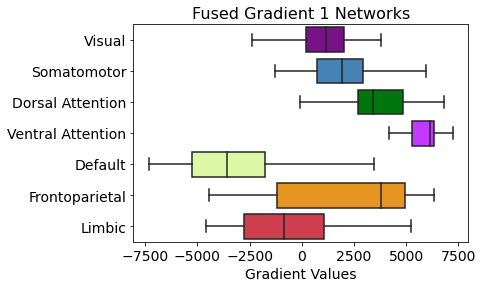

In [58]:
p = sns.boxplot(data=fuseG1_net, orient='h', saturation=1, showfliers=False, palette=yeo_cols)
p.tick_params(labelsize=14)
p.axes.set_title("Fused Gradient 1 Networks", fontsize=16)
p.set_xlabel("Gradient Values", fontsize=14)
plt.savefig(fig_path + f'Fused-matrix_G1-Gradient-weighted_cortical_networks.png',dpi=300, bbox_inches='tight')
plt.show()

In [59]:
sort_fuseG1 = fuseG1_net.mean().sort_values().index
sorted_fuseG1 = fuseG1_net[sort_fuseG1]

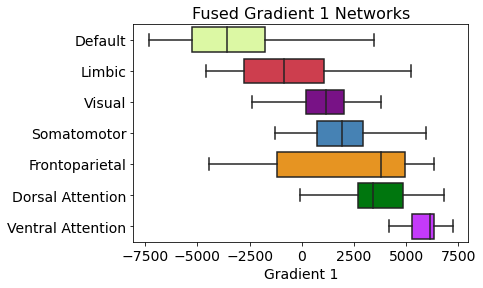

In [62]:
p = sns.boxplot(data=sorted_fuseG1, orient='h', saturation=1, showfliers=False, palette=yeo_cols)
p.tick_params(labelsize=14)
p.axes.set_title("Fused Gradient 1 Networks", fontsize=16)
p.set_xlabel("Gradient 1", fontsize=14)
plt.savefig(fig_path + f'Fused-matrix_G1-Gradient-weighted_cortical_networks_mean-sorted.png', dpi=300, bbox_inches='tight')
plt.show()

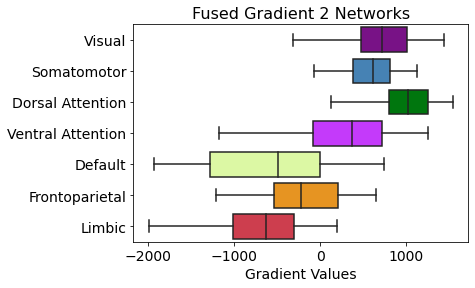

In [63]:
p = sns.boxplot(data=fuseG2_net, orient='h', saturation=1, showfliers=False, palette=yeo_cols)
p.tick_params(labelsize=14)
p.axes.set_title("Fused Gradient 2 Networks", fontsize=16)
p.set_xlabel("Gradient Values", fontsize=14)
plt.savefig(fig_path + f'Fused-matrix_G2-Gradient-weighted_cortical_networks.png',dpi=300, bbox_inches='tight')
plt.show()

In [64]:
sort_fuseG2 = fuseG2_net.mean().sort_values().index
sorted_fuseG2 = fuseG2_net[sort_fuseG2]

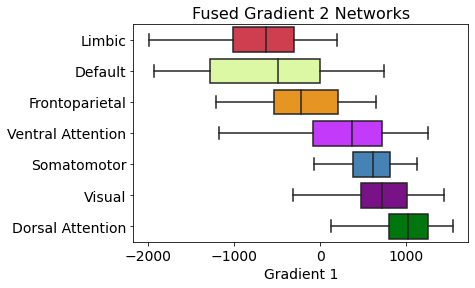

In [65]:
p = sns.boxplot(data=sorted_fuseG2, orient='h', saturation=1, showfliers=False, palette=yeo_cols)
p.tick_params(labelsize=14)
p.axes.set_title("Fused Gradient 2 Networks", fontsize=16)
p.set_xlabel("Gradient 1", fontsize=14)
plt.savefig(fig_path + f'Fused-matrix_G2-Gradient-weighted_cortical_networks_mean-sorted.png', dpi=300, bbox_inches='tight')
plt.show()

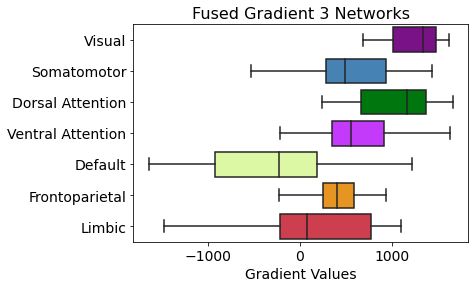

In [66]:
p = sns.boxplot(data=fuseG3_net, orient='h', saturation=1, showfliers=False, palette=yeo_cols)
p.tick_params(labelsize=14)
p.axes.set_title("Fused Gradient 3 Networks", fontsize=16)
p.set_xlabel("Gradient Values", fontsize=14)
plt.savefig(fig_path + f'Fused-matrix_G3-Gradient-weighted_cortical_networks.png',dpi=300, bbox_inches='tight')
plt.show()

In [67]:
sort_fuseG3 = fuseG3_net.mean().sort_values().index
sorted_fuseG3 = fuseG3_net[sort_fuseG3]

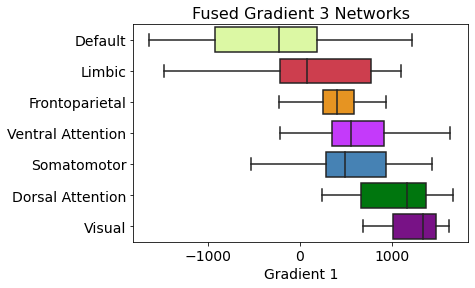

In [68]:
p = sns.boxplot(data=sorted_fuseG3, orient='h', saturation=1, showfliers=False, palette=yeo_cols)
p.tick_params(labelsize=14)
p.axes.set_title("Fused Gradient 3 Networks", fontsize=16)
p.set_xlabel("Gradient 1", fontsize=14)
plt.savefig(fig_path + f'Fused-matrix_G3-Gradient-weighted_cortical_networks_mean-sorted.png', dpi=300, bbox_inches='tight')
plt.show()